# Zero deforestation mission

## Labels:

**0**: "Plantation". Network of rectangular plantation blocks.

**1**: "Grassland/Shrubland". Large homogeneous areas with few trees.

**2**: "Smallholder Agriculture": Small scale area, in wich you can find deforestation covered by agriculture.

In [18]:
# Importing modules 
import numpy as np 
import pandas as pd 
import os
import matplotlib.pyplot as plt
import cv2

import tensorflow as tf

from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Dense,Conv2D,Flatten,MaxPool2D,Dropout, BatchNormalization, concatenate
from tensorflow.keras.models import Sequential

from sklearn.model_selection import train_test_split

np.random.seed(1)

In [19]:
df_train = pd.read_csv("train.csv")
df_test = pd.read_csv("test.csv")

display(df_test.head(2))

,latitude,longitude,year,example_path
0,0.761681,122.755954,2006,train_test_data/test/69.png
1,-8.059785,113.053791,2007,train_test_data/test/469.png


In [20]:
def calc_ndvi(image):
    b, g, r = cv2.split(image)
    bottom = (r.astype(float) + b.astype(float))
    bottom[bottom==0] = 0.01
    ndvi = (b.astype(float) - r) / bottom
    return ndvi

In [21]:
# Process training data.
train_images = []
train_path = df_train["example_path"].to_numpy()

for filename in train_path:
    img = cv2.imread(filename)
    ndvi = calc_ndvi(img)
    train_images.append(ndvi)

train_images = np.array(train_images)
train_images.shape

(1714, 332, 332)

In [22]:
# Process test data.
test_images = []
test_path = df_test["example_path"].to_numpy()

for filename in test_path:
    img = cv2.imread(filename)
    ndvi = calc_ndvi(img)
    test_images.append(ndvi)

test_images = np.array(test_images)
test_images.shape

(635, 332, 332)

In [23]:
df_train_features = df_train.drop("label", axis=1)
df_train_features = df_train_features.drop("example_path", axis=1)
display(df_train_features.head(5))

,latitude,longitude,year
0,-2.051853,111.826093,2001
1,-1.989349,105.309496,2013
2,1.223256,100.702217,2014
3,-2.342948,103.890226,2008
4,-0.126555,101.758175,2011


Here we remove all the attributes for the data CSVs, so we only work with the label. (Currently).

We also convert 0 to [1 0 0], 1 to [0 1 0], and 2 to [0 0 1]. Therefore, we can translate the ML algorithm into a multiple binary classification problem.

In [24]:
df_train_label = df_train.pop("label")
df_train_label = pd.get_dummies(df_train_label).values

In [25]:
X_train_features, X_val_features, X_train_images, X_val_images, y_train, y_val = train_test_split(df_train_features, train_images, df_train_label, random_state=1234)

So now, we have:

**X_train_features**: Features for training.

**X_train_images**: Images for training. (TRAINING)

**y_train**: Labels of the training images, so we can train. (TRAINING)



**X_val_images**: Images for validating the model. (VALIDATION)

**X_val_features**: Features for validation.

**y_val**: Labels of the validation set, so we can compare the results we predicted over X_val. (VALIDATION - F1 SCORE)


**test_images**: Like X_train or X_val, but for the final answer of the challenge (We don't know the labels).

In [26]:
# X_train_images = X_train_images / 255
# X_val_images = X_val_images / 255

X_train_images = X_train_images.reshape(-1, 332, 332, 1)
X_val_images = X_val_images.reshape(-1, 332, 332, 1)

In [27]:
train_samples = X_train_images.shape[0]
val_samples = X_val_images.shape[0]

array([0, 0, 1], dtype=uint8)

latitude        0.542971
longitude     120.912519
year         2004.000000
Name: 537, dtype: float64

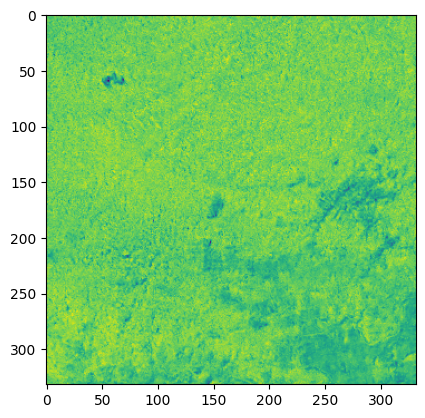

In [28]:
# Let's plot one of our examples.
display(y_train[0])
display(X_train_features.iloc[0])
plt.imshow(X_train_images[0])

[1 0 0]


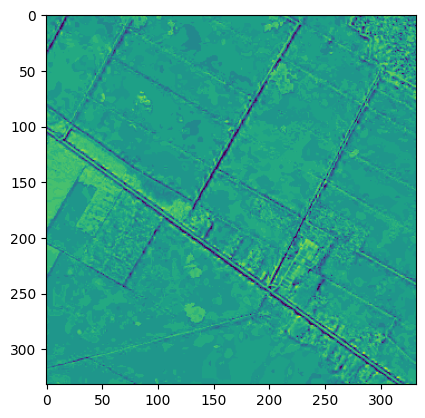

In [29]:
# Let's see a different one.
print(df_train_label[100])
plt.imshow(train_images[100])

In [30]:
X_train_features.shape

(1285, 3)

In [31]:
IMG_SIZE = 332
img_data_shape = (IMG_SIZE, IMG_SIZE, 1)
csv_data_shape = (3,)
num_classes = 3

# define two inputs layers
img_input = tf.keras.layers.Input(shape=img_data_shape, name="image")
csv_input = tf.keras.layers.Input(shape=csv_data_shape, name="csv")

# define layers for image data 
x1 = tf.keras.layers.experimental.preprocessing.Rescaling(1./255)(img_input)
x1 = tf.keras.layers.Conv2D(16, 3, padding='same', activation='relu', name="conv1_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp1_img")(x1)
x1 = tf.keras.layers.Conv2D(32, 3, padding='same', activation='relu', name="conv2_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp2_img")(x1)
x1 = tf.keras.layers.Conv2D(64, 3, padding='same', activation='relu', name="conv3_img")(x1)
x1 = tf.keras.layers.MaxPooling2D(name="mxp3_img")(x1)
x1 = tf.keras.layers.Flatten(name="flatten_img")(x1)

# define layers for csv data
x2 = tf.keras.layers.Flatten(name="flatten_csv")(csv_input)
x2 = tf.keras.layers.Dense(16, activation='relu', name="dense1_csv")(x2)
x2 = tf.keras.layers.Dense(32, activation='relu', name="dense2_csv")(x2)
x2 = tf.keras.layers.Dense(64, activation='relu', name="dense3_csv")(x2)

# merge layers
x = tf.keras.layers.concatenate([x1,x2], name="concat_csv_img")
x = tf.keras.layers.Dense(128, activation='relu', name="dense1_csv_img")(x)
output = tf.keras.layers.Dense(num_classes, name="classify")(x)

# make model with 2 inputs and 1 output
model = tf.keras.models.Model(inputs=[img_input, csv_input], outputs=output)

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

In [32]:
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
image (InputLayer)              [(None, 332, 332, 1) 0                                            
__________________________________________________________________________________________________
rescaling_1 (Rescaling)         (None, 332, 332, 1)  0           image[0][0]                      
__________________________________________________________________________________________________
conv1_img (Conv2D)              (None, 332, 332, 16) 160         rescaling_1[0][0]                
__________________________________________________________________________________________________
mxp1_img (MaxPooling2D)         (None, 166, 166, 16) 0           conv1_img[0][0]                  
____________________________________________________________________________________________

In [39]:
BATCH_SIZE = 8
dir_path = "train_test_data\\train"

X_train_images_tf = tf.keras.utils.image_dataset_from_directory(dir_path,
                                       validation_split=0.2, subset="training",
                                       seed=123, label_mode=None,
                                       image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)
X_val_images_tf = tf.keras.utils.image_dataset_from_directory(dir_path,
                                       validation_split=0.2, subset="validation",
                                       seed=123, label_mode=None,
                                       image_size=(IMG_SIZE, IMG_SIZE), batch_size=BATCH_SIZE)

Found 1714 files belonging to 1 classes.
Using 1372 files for training.
Found 1714 files belonging to 1 classes.
Using 342 files for validation.


In [40]:
X_train_features_tf = tf.data.Dataset.from_tensor_slices(X_train_features).batch(BATCH_SIZE)
X_val_features_tf = tf.data.Dataset.from_tensor_slices(X_val_features).batch(BATCH_SIZE)

y_train_tf = tf.data.Dataset.from_tensor_slices(y_train).batch(BATCH_SIZE)
y_val_tf = tf.data.Dataset.from_tensor_slices(y_val).batch(BATCH_SIZE)

In [42]:
def my_gen(subset):
    while True:
        if subset == "training":
            for i in X_train_images_tf.take(1):
                img_batch = i
            for j in X_train_features_tf.take(1):
                csv_batch = j
            for k in y_train_tf.take(1):
                labels_batch = k
        else:
            for i in X_val_images_tf.take(1):
                img_batch = i
            for j in X_val_features_tf.take(1):
                csv_batch = j
            for k in y_val_tf.take(1):
                labels_batch = k

        yield ((img_batch, csv_batch), labels_batch)

gen_train = my_gen("training")
gen_valid = my_gen("validation")

In [43]:
# Training the model.
batch_size = 8
#history = model.fit(X_train, y_train, epochs=50, steps_per_epoch=train_samples/batch_size, validation_steps=val_samples/batch_size, validation_data=(X_val, y_val))
# model.fit(
#     gen_train,
#     epochs=10,
#     steps_per_epoch=train_samples/batch_size,
#     validation_data=gen_valid,
#     validation_steps=val_samples/batch_size
# )

model.fit(gen_train, epochs=2, steps_per_epoch=3, validation_data=gen_valid, validation_steps=1)


Epoch 1/2


UnknownError:  Failed to get convolution algorithm. This is probably because cuDNN failed to initialize, so try looking to see if a warning log message was printed above.
	 [[node model_1/conv1_img/Conv2D (defined at C:\Users\danil\AppData\Local\Temp\ipykernel_11472\883357330.py:12) ]] [Op:__inference_train_function_1957]

Function call stack:
train_function


In [ ]:
# summarize history for accuracy
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

NameError: name 'history' is not defined